In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw
import pandas as pd
import numpy as np
import datetime
import os
# Custom functions
from useful_lca_functions import get_inventory_dataset, init_simple_lca, multi_lcia, multi_contribution_analysis, \
    calculate_projected_impacts
from visualisation_functions import plot_multilca_impacts, plot_multilca_impacts_multidb, plot_contribution_analysis, \
    plot_production_impacts, plot_incremental_impacts, plot_iwplus_contributions, plot_scenario_production_comparison

In [2]:
# Set projects, LCI and LCIA methods
BW_PROJECT = 'incremental_db'  # insert your project name here
bd.projects.set_current(BW_PROJECT)
bd.databases
EI_DB = 'ecoinvent-3.10-cutoff'
DB_2050 = [
    'image_26_50_elec',
    'image_26_50_heat',
    'image_26_50_fuels',
    'image_26_50_all',
]

DB = [
    'ecoinvent-3.10-cutoff',
    'image_26_50_elec',
    'image_26_50_heat',
    'image_26_50_fuels',
    'image_26_50_all'
]

## Import LCI

In [3]:
INVENTORIES = {
    "Aluminium": ("market for aluminium, primary, ingot", "aluminium, primary, ingot", "IAI Area, North America"),
    "Antimony": ("market for antimony", "antimony", "GLO"),
    "Cadmium": ("market for cadmium", "cadmium", "GLO"),
    "Cobalt": ("market for cobalt oxide", "cobalt oxide", "GLO"),
    "Copper": ("market for copper, cathode", "copper, cathode", "GLO"),
    "Fluorspar": ("market for fluorspar, 97% purity", "fluorspar, 97% purity", "GLO"),
    "Gold": ("market for gold", "gold", "GLO"),
    "Graphite": ("market for graphite", "graphite", "GLO"),
    "Indium": ("market for indium", "indium", "GLO"),
    "Iron (Fe)": ("market for iron ore, crude ore, 46% Fe", "iron ore, crude ore, 46% Fe", "GLO"),
    "Lead": ("market for lead", "lead", "GLO"),
    "Molybdenum": ("market for molybdenum", "molybdenum", "GLO"),
    "Nickel": ("market for nickel, class 1", "nickel, class 1", "GLO"),
    "Niobium (Nb2O5)": ("market for ferroniobium, 66% Nb", "ferroniobium, 66% Nb", "GLO"),
    "Palladium": ("market for palladium", "palladium", "GLO"),
    "Platinum": ("market for platinum", "platinum", "GLO"),
    "Potash (K2O)": ("market for potash salt", "potash salt", "RoW"),
    "Rhodium": ("market for rhodium", "rhodium", "GLO"),
    "Selenium": ("market for selenium", "selenium", "GLO"),
    "Silver": ("market for silver", "silver", "GLO"),
    "Tellurium": ("market for tellurium, semiconductor-grade", "tellurium, semiconductor-grade", "GLO"),
    "Titanium (TiO2)": ("market for titanium", "titanium", "GLO"),
    "Uranium (U3O8)": ("market for uranium hexafluoride", "uranium hexafluoride", "RoW"),
    "Zinc": ("market for zinc", "zinc", "GLO")
}
INVENTORIES_ds = get_inventory_dataset(INVENTORIES, database_names=DB)

## Pick LCIA methods

In [4]:
## Pick LCIA methods
ipcc_methods = [method for method in bd.methods if "ipcc 2021" in " ".join(method).lower()]
ipcc_methods
IMPACT_METHODS = {
    'GWP100': ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'),
}

## Calculations

In [5]:
# Calculate specific impacts (e.g. per mass)
def calculate_specific_lca_results(prospective_db, INVENTORIES, IMPACT_METHODS):
    """
    Calculates LCA results for each database in `prospective_db`.

    Parameters:
    - prospective_db (list): List of database names to iterate over.
    - INVENTORIES (dict): Dictionary of inventories to search in each database.
    - IMPACT_METHODS (dict): Dictionary of impact methods with names and method tuples.
    - get_inventory_dataset (function): Function to get inventory datasets for specified databases.
    - init_simple_lca (function): Function to initialize the LCA for specified activity.
    - multi_lcia (function): Function to calculate multiple impact categories.

    Returns:
    - dict: Dictionary of DataFrames with LCA results for each database.
    """
    # Initialize the dictionary to store results for each database
    specific_lca_results = {}

    # Iterate over each database
    for db_name in prospective_db:
        # Get inventory datasets from the specific database
        INVENTORIES_ds = get_inventory_dataset(INVENTORIES,
                                               [db_name])  # Pass as a list to search only in the current db

        # Dictionary to store LCA results for each raw material in the current database
        specific_lca = {}

        # Check if INVENTORIES_ds has results for the current database
        if INVENTORIES_ds:
            for rm, activity in INVENTORIES_ds.items():
                try:
                    # Initialize the LCA object without specifying a method
                    lca = init_simple_lca(activity)

                    # Calculate multiple impacts using `multi_lcia` with specified impact methods
                    impacts = multi_lcia(lca, activity, IMPACT_METHODS)

                    # Store the impacts for the current raw material
                    specific_lca[rm] = impacts

                except Exception as e:
                    print(f"Error processing {db_name} for {rm}: {e}")

            # Convert the specific LCA results for the current database to a DataFrame and store it
            specific_lca_results[db_name] = pd.DataFrame(specific_lca).T
        else:
            print(f"No inventory data found for database: {db_name}")

    return specific_lca_results


df = calculate_specific_lca_results(DB, INVENTORIES, IMPACT_METHODS)
series_list = []
for key, df in df.items():
    # Ensure you're selecting the column with GWP100 data, which is likely "GWP100 (kg CO2-Eq)"
    s = df["GWP100 (kg CO2-Eq)"].rename(key)
    series_list.append(s)

# Concatenate all series into a single DataFrame
combined_df = pd.concat(series_list, axis=1)
combined_df

,ecoinvent-3.10-cutoff,image_26_50_elec,image_26_50_heat,image_26_50_fuels,image_26_50_all
Aluminium,11.017602,6.947212,11.057628,11.001218,6.897075
Antimony,23.413275,8.635314,23.553766,23.308450,8.284312
Cadmium,3.781429,1.458141,3.795810,3.749433,1.384739
Cobalt,35.362758,30.189334,36.482016,34.855079,29.189653
Copper,6.995707,3.058157,7.043816,6.933928,2.873949
Fluorspar,0.211578,0.135694,0.213097,0.210471,0.130303
Gold,49991.841039,12146.607162,50100.206917,49639.170377,11639.254704
Graphite,0.072801,0.049227,0.072924,0.069527,0.039530
Indium,112.444455,42.046031,112.886416,111.593370,40.323829
Iron (Fe),0.009010,0.007261,0.009033,0.008568,0.006303


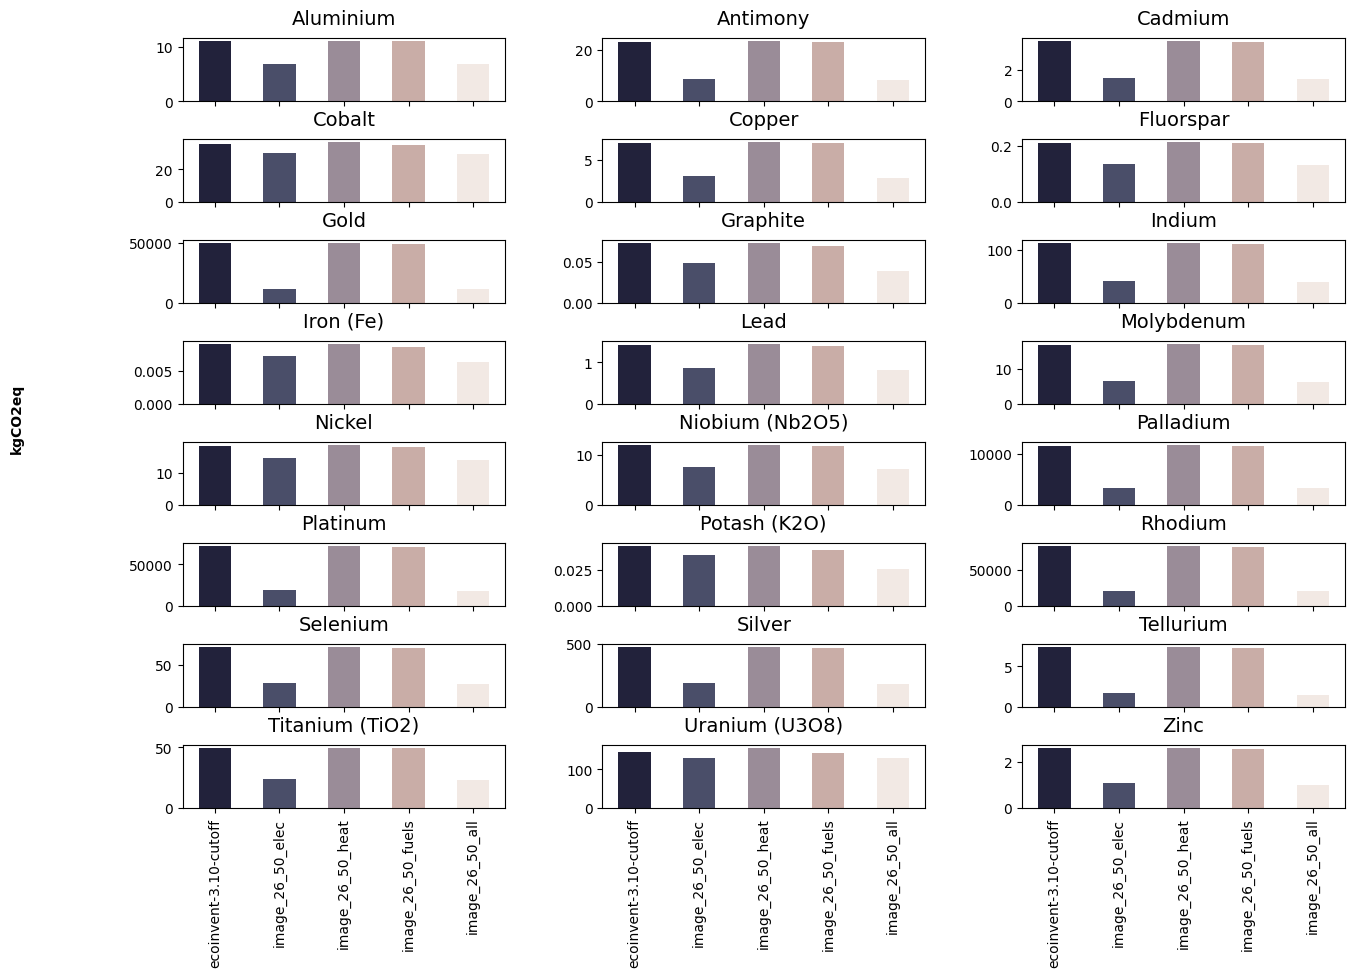

(<Figure size 1500x1000 with 24 Axes>,
 array([<Axes: title={'center': 'Aluminium'}>,
        <Axes: title={'center': 'Antimony'}>,
        <Axes: title={'center': 'Cadmium'}>,
        <Axes: title={'center': 'Cobalt'}>,
        <Axes: title={'center': 'Copper'}>,
        <Axes: title={'center': 'Fluorspar'}>,
        <Axes: title={'center': 'Gold'}>,
        <Axes: title={'center': 'Graphite'}>,
        <Axes: title={'center': 'Indium'}>,
        <Axes: title={'center': 'Iron (Fe)'}>,
        <Axes: title={'center': 'Lead'}>,
        <Axes: title={'center': 'Molybdenum'}>,
        <Axes: title={'center': 'Nickel'}>,
        <Axes: title={'center': 'Niobium (Nb2O5)'}>,
        <Axes: title={'center': 'Palladium'}>,
        <Axes: title={'center': 'Platinum'}>,
        <Axes: title={'center': 'Potash (K2O)'}>,
        <Axes: title={'center': 'Rhodium'}>,
        <Axes: title={'center': 'Selenium'}>,
        <Axes: title={'center': 'Silver'}>,
        <Axes: title={'center': 'Tellurium'}

In [6]:
def plot_minerals_comparison(
        df,
        color_map=None,
        ncols=3,
        figsize=(15, 10),
        title_fontsize=14,
        tick_fontsize=10,
        rotation=90,
        save_path=None
):
    """
    Plot comparison with y-axis ticks/labels on all subplots and x-axis ticks only on the bottom row.
    """
    import math
    import matplotlib.pyplot as plt

    # Handle color assignment
    if color_map is None:
        colors = ['gray'] * df.shape[1]
    else:
        colors = [color_map.get(col, 'gray') for col in df.columns]

    # Determine layout
    n_minerals = len(df)
    nrows = math.ceil(n_minerals / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=False)

    # Flatten axes for easy iteration
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Plot each mineral
    for idx, (ax, (mineral, row)) in enumerate(zip(axes, df.iterrows())):
        row.plot(kind='bar', ax=ax, color=colors)
        ax.set_title(mineral, fontsize=title_fontsize, pad=10)

        # Y-axis: Show ticks/labels on all subplots
        ax.tick_params(axis='y', labelsize=tick_fontsize)

        # X-axis: Show ticks/labels only on the bottom row
        if idx < len(axes) - ncols:
            ax.set_xticklabels([])
        else:
            ax.tick_params(axis='x', labelsize=tick_fontsize, rotation=rotation)

    # Hide unused axes
    for ax in axes[len(df):]:
        ax.set_visible(False)

    # Add a single common y-axis label
    fig.text(0.01, 0.5, 'kgCO2eq', va='center', rotation='vertical', fontsize=10, fontweight='bold')

    # Adjust layout for spacing
    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    # Save figure if needed
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig, axes


color_map = {
    'ecoinvent-3.10-cutoff': '#22223b',
    'image_26_50_elec': '#4a4e69',
    'image_26_50_heat': '#9a8c98',
    'image_26_50_fuels': '#c9ada7',
    'image_26_50_all': '#f2e9e4'
}

plot_minerals_comparison(
    combined_df,
    color_map=color_map,
    save_path='results/prospective_results/image26_2050_minerals.png'
)